#Mobile Payment Fraud Detection

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing Dataset 

In [ ]:
#Since Dataset Contains arond 6million data value we will train model for 50000 values
data = pd.read_csv('/content/drive/MyDrive/PBL 6th Sem/PS_20174392719_1491204439457_log.csv', nrows=50000)

In [ ]:
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            50000 non-null  int64  
 1   type            50000 non-null  object 
 2   amount          50000 non-null  float64
 3   nameOrig        50000 non-null  object 
 4   oldbalanceOrg   50000 non-null  float64
 5   newbalanceOrig  50000 non-null  float64
 6   nameDest        50000 non-null  object 
 7   oldbalanceDest  50000 non-null  float64
 8   newbalanceDest  50000 non-null  float64
 9   isFraud         50000 non-null  int64  
 10  isFlaggedFraud  50000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 4.2+ MB


In [ ]:
data['isFraud'].value_counts()

0    49900
1      100
Name: isFraud, dtype: int64

#Preprocessing 

In [ ]:
{column: len(data[column].unique()) for column in data.columns}

{'step': 9,
 'type': 5,
 'amount': 49786,
 'nameOrig': 50000,
 'oldbalanceOrg': 30572,
 'newbalanceOrig': 24328,
 'nameDest': 28499,
 'oldbalanceDest': 25369,
 'newbalanceDest': 9367,
 'isFraud': 2,
 'isFlaggedFraud': 1}

In [ ]:
data['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [ ]:
pd.get_dummies(data['type'], prefix='tp')

,tp_CASH_IN,tp_CASH_OUT,tp_DEBIT,tp_PAYMENT,tp_TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0
...,...,...,...,...,...
49995,0,0,0,1,0
49996,0,0,0,1,0
49997,0,0,0,1,0
49998,0,0,0,1,0


In [ ]:
#Using onehot_encoding to make the type column in more valuable data 
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [ ]:
def preprocess_inputs(df):
    df = df.copy()

    # Drop step, nameOrig, and isFlaggedFraud columns since wont affect the training of the model 
    df = df.drop(['step', 'nameOrig', 'isFlaggedFraud'], axis=1)
    
    # One-hot encode the type column
    df = onehot_encode(df, column='type', prefix='tp')
    
    y = df['isFraud'].copy()
    X = df.drop('isFraud', axis=1).copy()
     
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)


    #Using Dense encoder to make namedest column valuable, Create a tokenizer and fit it to the customer data
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(X_train['nameDest'])
    
    print("Total # of customers:", len(tokenizer.word_index))
      
    # Create tokenized customer lists
    customers_train = tokenizer.texts_to_sequences(X_train['nameDest'])
    customers_test = tokenizer.texts_to_sequences(X_test['nameDest'])
  
    # Pad sequences
    customers_train = tf.keras.preprocessing.sequence.pad_sequences(customers_train, maxlen=1)
    customers_test = tf.keras.preprocessing.sequence.pad_sequences(customers_test, maxlen=1)
    
    # Drop nameDest column
    X_train = X_train.drop('nameDest', axis=1)
    X_test = X_test.drop('nameDest', axis=1)
    
    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
#Final List of Dataset used for modeling 
    return X_train, X_test, customers_train, customers_test, y_train, y_test

In [ ]:
X_train, X_test, customers_train, customers_test, y_train, y_test = preprocess_inputs(data)

Total # of customers: 21017


In [ ]:
customers_train

array([[ 3450],
       [ 3451],
       [  579],
       ...,
       [ 1149],
       [  685],
       [21017]], dtype=int32)

In [ ]:
X_train.head(5)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,tp_CASH_IN,tp_CASH_OUT,tp_DEBIT,tp_PAYMENT,tp_TRANSFER
0,-0.476533,-0.331007,-0.333246,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425
1,-0.473382,-0.325069,-0.327862,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425
2,0.659963,0.315640,0.469088,2.728245,2.704851,2.147900,-0.618309,-0.115403,-0.880868,-0.324425
3,2.643818,-0.258553,-0.333403,2.149973,3.096149,-0.465571,-0.618309,-0.115403,-0.880868,3.082377
4,-0.476656,-0.322919,-0.325276,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425


In [ ]:
y_train.head(5)

17325    0
13544    0
49844    0
16371    0
13084    0
Name: isFraud, dtype: int64

#Handling Class Imbalance

In [ ]:
#Since there is very high gap between Value counts of isFraud(target Column)
#we will try to handle the class imbalance
train_df = pd.concat([X_train, pd.Series(np.squeeze(customers_train), name='customer'), y_train.reset_index(drop=True)], axis=1)
train_df.head(3)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,tp_CASH_IN,tp_CASH_OUT,tp_DEBIT,tp_PAYMENT,tp_TRANSFER,customer,isFraud
0,-0.476533,-0.331007,-0.333246,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,3450,0
1,-0.473382,-0.325069,-0.327862,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,1.135244,-0.324425,3451,0
2,0.659963,0.315640,0.469088,2.728245,2.704851,2.147900,-0.618309,-0.115403,-0.880868,-0.324425,579,0


In [ ]:
train_df['isFraud'].value_counts()

0    34929
1       71
Name: isFraud, dtype: int64

In [ ]:
print("Number of examples to sample:", 34929 - 71)

Number of examples to sample: 34858


In [ ]:
#Still the gap is very high
oversampled_data = train_df.query("isFraud == 1").sample(34858, replace=True, random_state=123)

In [ ]:
oversampled_data.head(3)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,tp_CASH_IN,tp_CASH_OUT,tp_DEBIT,tp_PAYMENT,tp_TRANSFER,customer,isFraud
33821,-0.408856,-0.321259,-0.333403,-0.343521,-0.388017,-0.465571,1.617313,-0.115403,-0.880868,-0.324425,1428,1
11627,-0.454176,-0.327894,-0.333403,-0.332356,-0.391365,-0.465571,1.617313,-0.115403,-0.880868,-0.324425,2108,1
28865,0.188942,-0.233736,-0.333403,-0.347251,-0.399715,-0.465571,-0.618309,-0.115403,-0.880868,3.082377,1378,1


In [ ]:
train_df = pd.concat([train_df, oversampled_data], axis=0).sample(frac=1.0, random_state=123).reset_index(drop=True)

In [ ]:
train_df['isFraud'].value_counts()

1    34929
0    34929
Name: isFraud, dtype: int64

In [ ]:
customers_train = train_df['customer'].copy()
y_train = train_df['isFraud'].copy()
X_train = train_df.drop(['customer', 'isFraud'], axis=1).copy()

#Modeling

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_input (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 customer_input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 X_dense1 (Dense)               (None, 64)           704         ['X_input[0][0]']                
                                                                                                  
 customer_embedding (Embedding)  (None, 1, 64)       1345152     ['customer_input[0][0]']         
                                                                                              

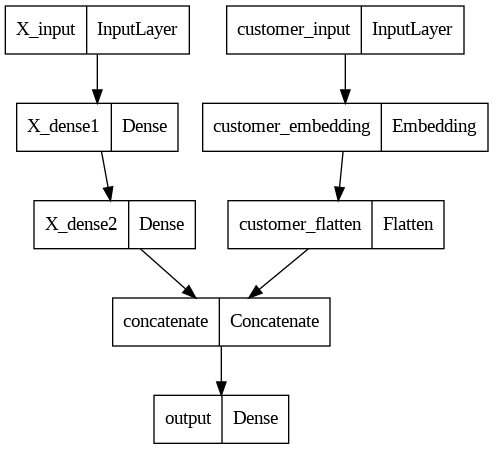

In [ ]:
# Inputs
X_inputs = tf.keras.Input(shape=(10,), name='X_input')
customer_inputs = tf.keras.Input(shape=(1,), name='customer_input')

# X
X_dense1 = tf.keras.layers.Dense(64, activation='relu', name='X_dense1')(X_inputs)
X_dense2 = tf.keras.layers.Dense(64, activation='relu', name='X_dense2')(X_dense1)

# customers
customer_embedding = tf.keras.layers.Embedding(
    input_dim=21018,
    output_dim=64,
    input_length=1,
    name='customer_embedding'
)(customer_inputs)
customer_flatten = tf.keras.layers.Flatten(name='customer_flatten')(customer_embedding)
# Concatenate
concat = tf.keras.layers.concatenate([X_dense2, customer_flatten], name='concatenate')

# Output
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(concat)


model = tf.keras.Model(inputs=[X_inputs, customer_inputs], outputs=outputs)

print(model.summary())
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

#Training

In [ ]:
history = model.fit(
    [X_train, customers_train],
    y_train,
    validation_split=0.2,
    class_weight={
        0: 0.25,
        1: 4.0
    },
    batch_size=32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
1747/1747 [==============================] - 39s 21ms/step - loss: 0.0652 - accuracy: 0.9369 - auc: 0.9955 - val_loss: 0.0126 - val_accuracy: 0.9978 - val_auc: 0.9989
Epoch 2/10
1747/1747 [==============================] - 34s 20ms/step - loss: 0.0036 - accuracy: 0.9981 - auc: 0.9989 - val_loss: 0.0080 - val_accuracy: 0.9985 - val_auc: 0.9994
Epoch 3/10
1747/1747 [==============================] - 36s 21ms/step - loss: 0.0031 - accuracy: 0.9984 - auc: 0.9990 - val_loss: 0.0190 - val_accuracy: 0.9981 - val_auc: 0.9984
Epoch 4/10
1747/1747 [==============================] - 35s 20ms/step - loss: 0.0028 - accuracy: 0.9984 - auc: 0.9990 - val_loss: 0.0098 - val_accuracy: 0.9986 - val_auc: 0.9993


#Results

In [ ]:
results = model.evaluate([X_test, customers_test], y_test, verbose=0)
print("Test Accuracy: {:.3f}%".format(results[1] * 100))
print("     Test AUC: {:.3f}".format(results[2] * 100))

Test Accuracy: 99.647%
     Test AUC: 89.901


In [ ]:
y_true = np.array(y_test)

y_pred = np.squeeze(model.predict([X_test, customers_test]))
y_pred = (y_pred >= 0.5).astype(np.int)


cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=["Not Fraud", "Fraud"])

469/469 [==============================] - 1s 1ms/step


<ipython-input-27-5d190804a4e5>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = (y_pred >= 0.5).astype(np.int)


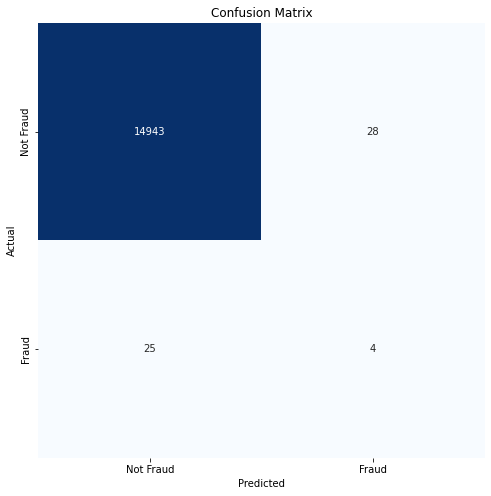

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(2) + 0.5, ["Not Fraud", "Fraud"])
plt.yticks(np.arange(2) + 0.5, ["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     14971
       Fraud       0.12      0.14      0.13        29

    accuracy                           1.00     15000
   macro avg       0.56      0.57      0.56     15000
weighted avg       1.00      1.00      1.00     15000

